# 4. Compound clustering

By leveraging the concept of chemical similarity, compound clustering can be a powerful tool for identifying promising candidate molecules for further investigation.

## The principle of similarity

Compounds with similar structures often exhibit comparable biological activity due to their ability to interact with the same receptor sites within the body.
This principle forms the foundation of compound clustering: grouping molecules based on their chemical resemblance.

## Introduction to Clustering Algorithm:

Clustering, the core concept of our project, involves categorizing a collection of objects in a manner that items within the same cluster exhibit a greater level of resemblance to each other than to those in separate clusters. We explore various clustering algorithms such as K-means and density based clustering algorithms

## Butina clustering

In addition to classic clustering algorithm, we delve into Butina clustering, a method that aims to identify smaller but homogeneous clusters. This approach is valuable for creating more focused subsets of compounds with similar characteristics, allowing for more targeted analysis and evaluation.

In [1]:
import time
import random
from pathlib import Path
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
import logging
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import warnings
from sklearn.cluster import KMeans
import hdbscan

In [2]:
compound_df = pd.read_csv('data/compounds_lipinski_no_pains.csv',
    index_col=0,
)
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (3311, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
7,CHEMBL3660114,0.20,nM,Cc1ncc(C#Cc2c(C)ncnc2N2CCOC[C@@H]2C)cc1NS(=O)(...,9.698970,<rdkit.Chem.rdchem.Mol object at 0x2af924e34cf0>,463.167811,7,1,2.91414,True
16,CHEMBL3655894,0.28,nM,Cc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1c...,9.552842,<rdkit.Chem.rdchem.Mol object at 0x2af924e34d60>,449.152161,7,1,2.52564,True
18,CHEMBL3660127,0.30,nM,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.522879,<rdkit.Chem.rdchem.Mol object at 0x2af924e34dd0>,499.108103,8,1,2.87922,True
21,CHEMBL3660129,0.39,nM,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.408935,<rdkit.Chem.rdchem.Mol object at 0x2af924e34e40>,471.103496,9,1,2.28732,True
22,CHEMBL1083912,0.40,nM,CNC(=O)Nc1ccc2c(c1)C(=O)/C(=C\c1c(-c3c(C)nn(C)...,9.397940,<rdkit.Chem.rdchem.Mol object at 0x2af924e34eb0>,471.190654,6,3,4.56134,True


In [3]:
def convert_smiles_to_molecules(compound_df):
    """Convert SMILES strings to RDKit molecules."""
    molecules = []
    for _, row in compound_df.iterrows():
        try:
            molecule = Chem.MolFromSmiles(row["smiles"])
            molecules.append((molecule, row["molecule_chembl_id"]))
        except Exception as e:
            logging.warning(f"Failed to convert SMILES to molecule: {e}")
    logging.info("Conversion of SMILES to molecules completed.")
    return molecules

In [4]:
# Convert SMILES strings to molecules
molecules = convert_smiles_to_molecules(compound_df)
molecules[:10]

[(<rdkit.Chem.rdchem.Mol at 0x2aca37db52e0>, 'CHEMBL3660114'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db55f0>, 'CHEMBL3655894'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db5660>, 'CHEMBL3660127'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db56d0>, 'CHEMBL3660129'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db5740>, 'CHEMBL1083912'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db57b0>, 'CHEMBL1083305'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db5820>, 'CHEMBL4515169'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db5890>, 'CHEMBL3655855'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db5900>, 'CHEMBL3655884'),
 (<rdkit.Chem.rdchem.Mol at 0x2aca37db5970>, 'CHEMBL3660101')]

In [5]:
def generate_fingerprints(molecules):
    """Generate fingerprints for molecules."""
    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
    fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, _ in molecules]
    logging.info("Fingerprints generated for molecules.")
    return fingerprints

In [6]:
# Generate fingerprints for molecules
fingerprints = generate_fingerprints(molecules)

In [7]:
# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))

Number of compounds converted: 3311
Fingerprint length per compound: 2048


## Bunita Clustering

In [8]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = []
        for j in range(i):
            similarity = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
            similarities.append(1 - similarity)  # Convert similarity to distance
        dissimilarity_matrix.extend(similarities)
    return dissimilarity_matrix

In [9]:
def cluster_fingerprints_butina(fingerprints, cutoff=0.1):
    """Cluster fingerprints using Butina algorithm"""
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [10]:
# Run clustering procedures for the dataset
clusters_butina = cluster_fingerprints_butina(fingerprints, cutoff=0.1)

In [11]:
# Compare the performance of both clustering algorithms
num_clusters_butina = len(clusters_butina)

print("Number of clusters (Butina):", num_clusters_butina)

Number of clusters (Butina): 1406


In [12]:
# Visualize example clusters
def visualize_clusters(molecules, clusters, num_clusters=5):
    for i in range(num_clusters):
        cluster_size = len(clusters[i])
        print(f"Cluster {i+1} Size: {cluster_size}")
        Draw.MolsToGridImage([molecules[idx][0] for idx in clusters[i]], legends=[molecules[idx][1] for idx in clusters[i]], molsPerRow=min(5, cluster_size), subImgSize=(300, 300))

# Visualize example clusters for Butina
print("Example Clusters for Butina Clustering:")
visualize_clusters(molecules, clusters_butina)

Example Clusters for Butina Clustering:
Cluster 1 Size: 118


/home/kanku.d/.local/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


Cluster 2 Size: 43
Cluster 3 Size: 30
Cluster 4 Size: 29
Cluster 5 Size: 29


In [13]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
def visualize_clusters_pca(molecules, clusters, num_clusters=5):
    # Create a PCA object to reduce the dimensionality of the fingerprints to 2 dimensions
    pca = PCA(n_components=2)
    
    for i in range(num_clusters):
        cluster_size = len(clusters[i])
        print(f"Cluster {i+1} Size: {cluster_size}")
        # Extract fingerprints for compounds in the cluster
        cluster_fps = [rdkit_gen.GetFingerprint(molecules[idx][0]) for idx in clusters[i]]
        # Reduce dimensionality using PCA
        reduced_fps = pca.fit_transform(cluster_fps)
        # Plot the compounds in the cluster
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_fps[:, 0], reduced_fps[:, 1], label=f"Cluster {i+1}")
        plt.title(f"Cluster {i+1} Visualization")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend()
        plt.show()

Example Clusters for Butina Clustering:
Cluster 1 Size: 118


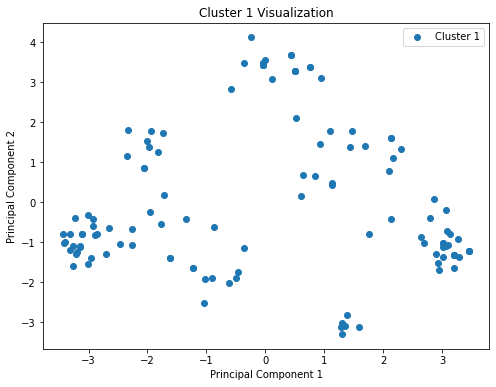

Cluster 2 Size: 43


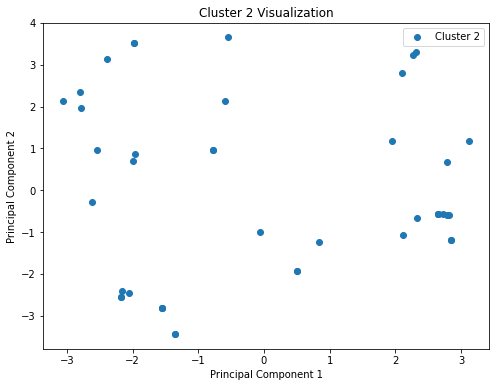

Cluster 3 Size: 30


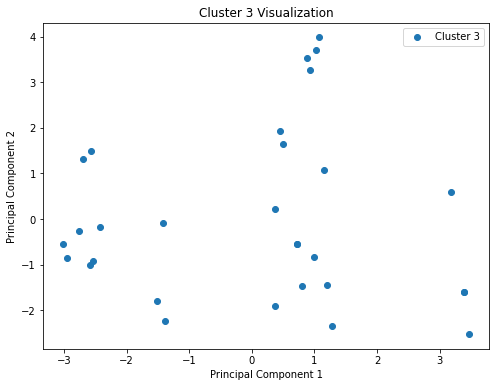

Cluster 4 Size: 29


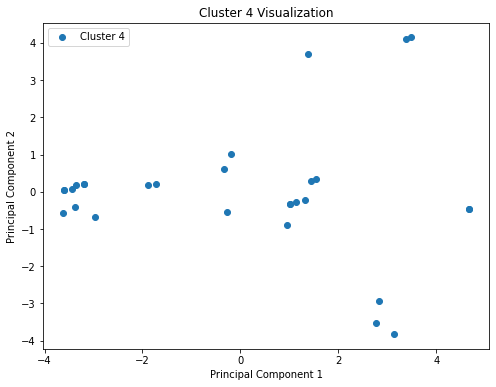

Cluster 5 Size: 29


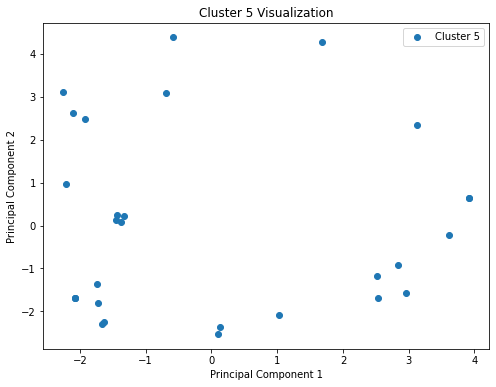

In [14]:
# Visualize example clusters for Butina using PCA
print("Example Clusters for Butina Clustering:")
visualize_clusters_pca(molecules, clusters_butina)

Ten molecules from largest cluster:


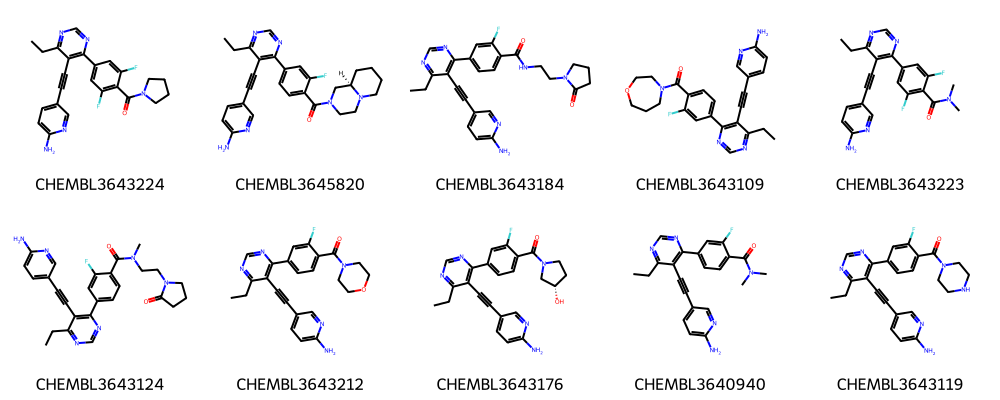

In [15]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [molecules[i][0] for i in clusters_butina[0][:10]],
    legends=[molecules[i][1] for i in clusters_butina[0][:10]],
    molsPerRow=5,
)

In [16]:
# Save molecules from largest cluster
sdf_path = str("data/molecule_set_largest_cluster_butina.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters_butina[0]:
    mol, label = molecules[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

In [17]:
# Generate image
img = Draw.MolsToGridImage(
    [molecules[clusters_butina[i][0]][0] for i in range(0, 3)],
    legends=[f"Cluster {i}" for i in range(1, 4)],
    subImgSize=(200, 200),
    useSVG=True,
)

# Patch RAW svg data: convert non-transparent to transparent background and set font size
molsvg = img.data.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open("cluster_representatives.svg", "w") as f:
    f.write(molsvg)

In [18]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [19]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters_butina[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(molecules[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

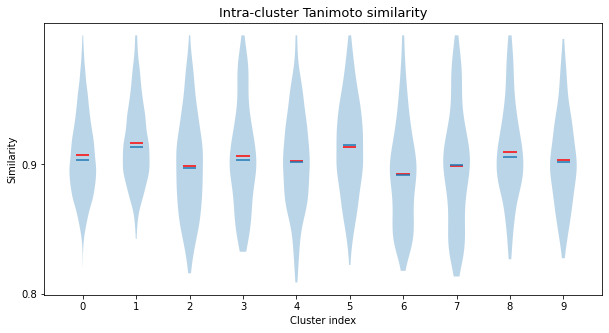

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(np.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")

In [22]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [molecules[c[0]] for c in clusters_butina]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))

Number of cluster centers: 1406


In [23]:
def compute_diversity(cluster_compounds):
    # Compute fingerprints for all compounds in the cluster
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(compound[0], 2, nBits=1024) for compound in cluster_compounds]
    
    # Calculate pairwise Tanimoto similarity between fingerprints
    diversity_scores = []
    for i in range(len(fingerprints)):
        similarity_sum = 0.0
        for j in range(len(fingerprints)):
            if i != j:
                similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
                similarity_sum += similarity
        # Calculate average similarity as diversity score
        diversity_score = similarity_sum / (len(fingerprints) - 1)
        diversity_scores.append(diversity_score)
    
    return diversity_scores

In [24]:
def sort_compounds_by_score(cluster_compounds, diversity_scores):
    """Sort molecules within the cluster based on diversity scores."""
    sorted_compounds = [compound for _, compound in sorted(zip(diversity_scores, cluster_compounds), key=lambda x: x[0], reverse=True)]
    return sorted_compounds

def select_representative_compounds(sorted_cluster, num_representatives=10):
    """Select a representative subset of molecules from the sorted cluster."""
    return sorted_cluster[:num_representatives]

In [25]:
def select_representative_molecules(compounds, clusters, num_max_molecules=1000):
    selected_molecules = []
    for cluster in clusters:
        cluster_compounds = [compounds[i] for i in cluster]
        diversity_scores = compute_diversity(cluster_compounds)
        sorted_cluster = sort_compounds_by_score(cluster_compounds, diversity_scores)
        selected_compounds = select_representative_compounds(sorted_cluster)
        selected_molecules += selected_compounds
        if len(selected_molecules) >= num_max_molecules:
            break
    return selected_molecules

In [26]:
selected_molecules = select_representative_molecules(molecules, clusters_butina, num_max_molecules=1000)
print("Number of selected molecules:",len(selected_molecules))

Number of selected molecules: 1001


In [27]:
# Function to evaluate clustering quality using silhouette score
def evaluate_clustering_quality(compounds, clusters):
    compound_features = [rdkit_gen.GetFingerprint(comp[0]) for comp in compounds]
    cluster_labels = [label for label, cluster in enumerate(clusters) for _ in cluster]
    silhouette = silhouette_score(compound_features, cluster_labels)
    print(f"Silhouette Score: {silhouette}")

In [28]:
# Evaluate clustering quality
evaluate_clustering_quality(molecules, clusters_butina)

Silhouette Score: -0.3902886801629674


## K-Means Clustering

In [29]:
# Generate molecular descriptors
warnings.filterwarnings("ignore", category=UserWarning, module="threadpoolctl")
def generate_descriptors(molecules):
    descriptors = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol, _ in molecules]
    return np.array(descriptors)

descriptors = generate_descriptors(molecules)

In [30]:
warnings.filterwarnings("ignore", category=UserWarning, module="threadpoolctl")
# Dimensionality reduction with t-SNE
def apply_tsne(descriptors, n_components=2):
    tsne = TSNE(n_components=n_components)
    embeddings = tsne.fit_transform(descriptors)
    return embeddings

embeddings = apply_tsne(descriptors)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2aca3cb23700>
Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [31]:
warnings.filterwarnings("ignore", category=UserWarning, module="threadpoolctl")
# Clustering with KMeans
def cluster_with_kmeans(embeddings, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels

In [35]:
cluster_labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

/home/kanku.d/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2aca3cc2b4c0>
Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/shared/centos7/anaconda3/2021.05/lib/pyt

Silhouette Score: 0.40103787183761597


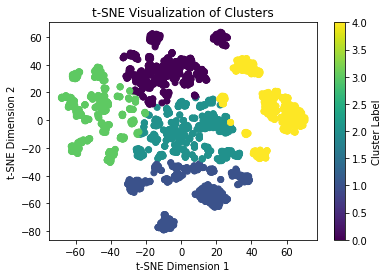

In [32]:
# Filter out threadpoolctl warnings
warnings.filterwarnings("ignore", category=UserWarning, module="threadpoolctl")

cluster_labels = cluster_with_kmeans(embeddings)

# Evaluate clustering quality
silhouette = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score: {silhouette}")

# Visualize clusters with t-SNE embeddings
def visualize_clusters(embeddings, cluster_labels):
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization of Clusters')
    plt.colorbar(label='Cluster Label')
    plt.show()
visualize_clusters(embeddings, cluster_labels)

In [33]:
!pip install hdbscan

Defaulting to user installation because normal site-packages is not writeable


In [34]:
# Density-based clustering with HDBSCAN
def cluster_with_hdbscan(embeddings, min_cluster_size=10):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster_labels_hdbscan = clusterer.fit_predict(embeddings)
    return cluster_labels_hdbscan

cluster_labels_hdbscan = cluster_with_hdbscan(embeddings)

# Evaluate clustering quality with HDBSCAN
silhouette_hdbscan = silhouette_score(embeddings, cluster_labels_hdbscan)
print(f"Silhouette Score (HDBSCAN): {silhouette_hdbscan}")

Silhouette Score (HDBSCAN): 0.5292263031005859
